In [9]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
TREE_DIR = '../../data/vtrees/'

######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['donor_tissue'] = df['donor'] + "_" + df['tissue']

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid_gex']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]

# omit multiple lymph nodes to avoid a biased view of lineages
df = df[(df.donor=='TBd6') & (~(df.tissue=='LN') | (df.sample_uid.str.contains('SDLN3')))]
print(df.sample_uid.value_counts())


TBd6_fresh_SDLN3over    44248
TBd6_fresh_SPover       37864
TBd6_fresh_BMover       35064
TBd6_fresh_PBover       22869
TBd6_fresh_PB           22174
TBd6_fresh_SDLN3        11797
TBd6_fresh_SP           11308
TBd6_fresh_BM            7669
Name: sample_uid, dtype: int64


In [11]:
lineage_sizes = df.groupby(['donor','tissue','lineage_id'])['vdj_sequence'].nunique()

lineage_sizes = lineage_sizes.reset_index()

lineage_ids_by_size = lineage_sizes.set_index(['donor','lineage_id'])['vdj_sequence'].sort_values(ascending=False)


### Load tree data

In [12]:

############## PATHS ######################
tree_filename = lambda donor: f'{TREE_DIR}/{donor}_v_trees.tsv'
msa_filename = lambda donor: f'{TREE_DIR}/{donor}_vmsa.tsv.gz'
############## ***** ######################

msa_df = []
tree_df = []
for donor in ['TBd6']:
    v_msa_df = pd.read_table(msa_filename(donor))
    v_msa_df['donor'] = donor
    v_msa_df = v_msa_df[v_msa_df.v_sequence.notna()]
    msa_df.append(v_msa_df)

    nwk_tree_df = pd.read_table(tree_filename(donor))
    nwk_tree_df['donor'] = donor
    tree_df.append(nwk_tree_df)

    
msa_df = pd.concat(msa_df, axis=0)

tree_df = pd.concat(tree_df, axis=0)
tree_df['lineage_uid'] = tree_df['donor'] +"_" + tree_df['lineage_id'].astype(str)
tree_df = tree_df.set_index('lineage_uid')

join_cols = ['v_sequence','donor','lineage_id']
for col in join_cols:
    df[col] = df[col].astype(str)
    msa_df[col] = msa_df[col].astype(str)
    df_clean[col] = df_clean[col].astype(str)
    
full_df = df[df['vdj_sequence'].notna()].merge(msa_df, on=join_cols, how='inner')


In [13]:
full_df['v_seq_len'] = full_df.v_sequence.str.len()
full_df['lineage_uid'] = full_df['donor'] +"_" + full_df['lineage_id'].astype(str)


In [14]:
mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.Set2(np.linspace(0,1,8)))

from Bio import Phylo
from io import StringIO

from plot_tree_helper import *
def draw_tree(target_lineage, df, tree_df, color_by='tissue', 
              collapse_multiple=False, 
              facecolor_dict=None, 
              edgecolor_dict=None,
              marker_dict=None, fig_y_scale=1):
    
    # set up tree data structure
    lineage_df = df[df.lineage_uid == target_lineage]
    tree_nwk = tree_df.loc[target_lineage, 'v_phylogeny']
    

    vseq_df=lineage_df[['v_seq_id','v_mismatch',color_by,'v_seq_len','n_umis']]
    vseq_df = vseq_df.groupby(['v_seq_id',
                               'v_mismatch',
                               'v_seq_len'])[[color_by,
                                            'n_umis']].agg({color_by:set,
                                                                'n_umis':sum}).reset_index()
    vseq_df = vseq_df.rename(columns={0:color_by})
    multi_tissue = vseq_df[color_by].str.len() > 2

    if collapse_multiple:
        vseq_df.loc[multi_tissue, color_by] = '3 or more'
        vseq_df[color_by] = vseq_df[color_by].apply(lambda x: x if x == '3 or more' else ",".join(sorted(list(set(x)))))
    else:
        vseq_df[color_by] = vseq_df[color_by].map(lambda x: ",".join(sorted(list(set(x)))))
    
    vseq_df=vseq_df.reset_index().set_index('v_seq_id')
    subsets = sorted(vseq_df[color_by].unique())
    tree = Phylo.read(StringIO(tree_nwk), 'newick')
            
    # drop clade if v_seq_id is missing -- these were likely discarded after the MSA step
    for clade in tree.get_terminals():
        if clade.name:
            if not('inferred' in clade.name):
                if clade.name in vseq_df.index:
                    pass
                else:
                    tree.prune(clade)

    #root on clade closest to germline
    min_d=300
    idx_min=-1
    closest_clade = None
    for clade in tree.find_clades():
        if clade.name:
            if 'inferred' in clade.name:
                d=0
                closest_clade = clade
                break
            else:
                d = vseq_df.loc[clade.name,'v_mismatch'].astype(int)

            if d < min_d:
                min_d = d
                idx_min = clade.name
                closest_clade = clade

    tree.root_with_outgroup(closest_clade)
    tree.ladderize()
    tree.rooted = True

    
    x_positions = get_x_positions(tree)
    y_positions = get_y_positions(tree)
    xvals = np.asarray(list(x_positions.values()))
    x_range = xvals.max() - xvals.min()
    # set tree style
    tree_color = 'k'
    tree.root.color= tree_color
    tree.root.width = 0.3
    fig_height = fig_y_scale*0.06*len(tree.get_terminals())
    fig_width = 10*x_range

    fig, ax = pylab.subplots(figsize=(fig_width,fig_height))


    if facecolor_dict is None:
        facecolor_dict = {}

    if edgecolor_dict is None:
        edgecolor_dict = {}

    if marker_dict is None:
        marker_dict = {}
        print("Using default markers for all leaves")
    
    for feature in subsets:
        if feature in facecolor_dict.keys():
            fc = facecolor_dict.get(feature)
            ec = edgecolor_dict.get(feature)
            m = marker_dict.get(feature, 'o')
            if str(fc) == str(ec):
                additional_kwargs={}
            else:
                additional_kwargs=dict(hatch=r"|||")
            if str(fc) == str(ec):        
                ax.scatter([],[],marker=m,label=feature, facecolor=fc,
                                                           edgecolor=ec,
                                                           lw=0,
                                                           **additional_kwargs)
        else:
            line1, = ax.plot([],[],'o',label=feature)
            facecolor_dict.update({feature:line1.get_color()})
            edgecolor_dict.update({feature:(0,0,0,1.)})
            
    facecolor_dict['multiple'] = 'k'
    edgecolor_dict['multiple'] = (0,0,0,1.)
    
    for clade_id in x_positions.keys():
        if (clade_id.name is None) or (clade_id.name.startswith("Inner")):
            pass
        else:
            x = x_positions[clade_id]
            y = y_positions[clade_id]


            if clade_id.name.endswith("inferred"):
                kwargs = dict(facecolor='0.5',
                              lw=.5,
                              edgecolor=(0,0,0,1.),
                              zorder=10,
                              alpha=.6)
                plot_twice=False
                # don't plot inferred leaves
                continue
            else:
                clade_subset = vseq_df.loc[clade_id.name, color_by]
                fc = facecolor_dict[clade_subset]
                ec = edgecolor_dict[clade_subset]
                m = marker_dict[clade_subset]
                alpha=1.
                
                if str(fc) == str(ec):
                    plot_twice=False
                else:
                    plot_twice=True
            
    
                if (clade_id.name == idx_min) and (vseq_df.loc[clade_id.name, 'v_mismatch'] == 0):
                    kwargs =dict(facecolor=fc,
                                 marker = m,
                                   lw=.0,
                                   edgecolor=(0,0,0,1.),
                                   zorder=10,
                                   alpha=alpha)
                    kwargs.update(additional_kwargs)
                else:


                    kwargs = dict(facecolor=fc,
                                  marker=m,
                                  lw=0.,
                                  edgecolor=fc,
                                  zorder=10,
                                  # size=s,
                                  alpha=alpha)
                    kwargs.update(additional_kwargs)

                if plot_twice:
                    kwargs["edgecolor"] = 'k'
                    kwargs['lw'] = 0.3
                    kwargs['zorder'] = 100

            ax.scatter(x,y, s=10, clip_on=False, **kwargs)

            if plot_twice:
                kwargs["marker"] = MarkerStyle('D', fillstyle="bottom")
                kwargs["facecolor"] = ec
                kwargs["edgecolor"] = 'k'
                kwargs['lw'] = 0.3
                kwargs['zorder'] = 100
                ax.scatter(x,y, s=10, clip_on=False, **kwargs)


    Phylo.draw(tree,
           label_func=lambda x: "",
           do_show=False,
           show_confidence=False, 
           axes = ax
           )
    ax.axis('off')
    ax.set_ylim([-16,ax.get_ylim()[0]])

    ax.set_xlim([-0.05,ax.get_xlim()[1]])
    ax.plot([0.00, 0.05], [-10,-10], color = 'k')
    ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.1,1), handlelength=0.5)
    
    return fig, ax


### Draw trees

In [15]:
facecolor_dict = {}
edgecolor_dict = {}
marker_dict = {}

tissue_list = ['PB','BM','SP','LN']
for t1,t2 in combinations(tissue_list,2):
    for t in [t1, t2]:
        facecolor_dict[t] = tissue_colors[t]
        edgecolor_dict[t] = tissue_colors[t]
        marker_dict[t] = 'o'
    facecolor_dict[f"{t1},{t2}"] = tissue_colors[t1]
    edgecolor_dict[f"{t1},{t2}"] = tissue_colors[t2]
    facecolor_dict[f"{t2},{t1}"] = tissue_colors[t1]
    edgecolor_dict[f"{t2},{t1}"] = tissue_colors[t2]
    marker_dict[f"{t1},{t2}"] = MarkerStyle('D', fillstyle="top") #marker=MarkerStyle("o", fillstyle="left")
    marker_dict[f"{t2},{t1}"] = MarkerStyle('D', fillstyle="top")
edgecolor_dict['3 or more'] = 'k'
facecolor_dict['3 or more'] = 'k'
marker_dict['3 or more'] = 'D'


TBd6
3
76
85


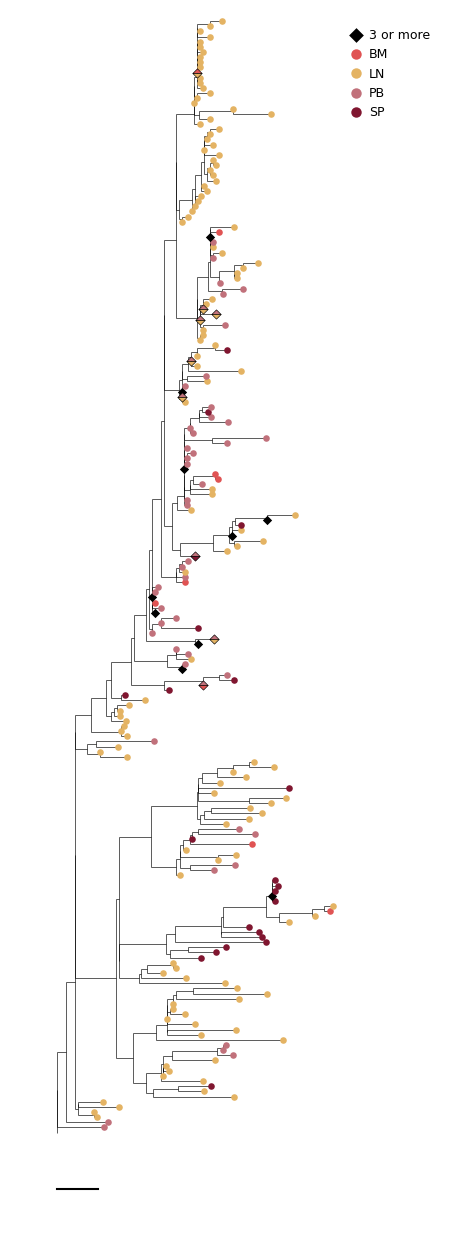

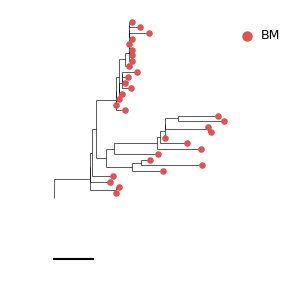

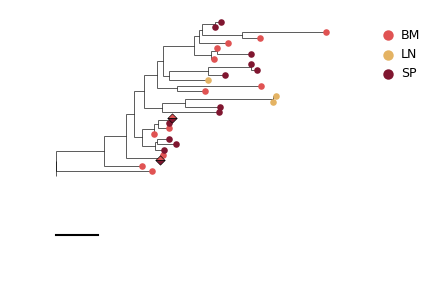

In [16]:

for donor in ['TBd6']:
    print(donor)
    for i in [3, 76, 85]:
        print(i)
        subset = tree_df.donor==donor
        scale = 1.2 if i > 3 else 0.8
        fig, ax = draw_tree(tree_df[subset].iloc[i].name, full_df, tree_df, color_by='tissue', 
                            facecolor_dict=facecolor_dict,
                            edgecolor_dict=edgecolor_dict,
                            marker_dict=marker_dict,
                            collapse_multiple=True,
                            fig_y_scale=scale)
        
        fig.savefig(f'../figures/paper figures/Figure3/{donor}_tree{i+1}.pdf', bbox_inches='tight')
